# Urbanization Process and Population in Modern China

##### Ame Liu 22910358

Based on CITS4403

In [365]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import folium
import os
from time import sleep
from IPython.display import clear_output
mpl.rcParams['lines.linewidth'] = 2.0

## Preparation

In [366]:
def three_frame(world, n_seq, seed=17):
    np.random.seed(seed)
    plt.figure(figsize=(10, 4))

    for i, n in enumerate(n_seq):
        plt.subplot(1, 3, i+1)
        world.loop(n)
        world.draw()

    plt.tight_layout()


def savefig(filename, **options):
    print("Saving figure to file", filename)
    plt.savefig(filename, **options)


def underride(d, **options):
    for key, val in options.items():
        d.setdefault(key, val)

    return d


def decorate(**options):
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()


def legend(**options):
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def draw_array(array, **options):
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

## Parent class for 2-D cellular automata

In [367]:
class Cell2D:
    def __init__(self, n, m=None):
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1):
        for i in range(iters):
            self.step()

    def draw(self, **options):
        draw_array(self.array, **options)

    def animate(self, frames, interval=None, step=None):
        if step is None:
            step = self.step

        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass



def distances_from(n, i, j):
    X, Y = np.indices((n, n))
    return np.hypot(X - i, Y - j)


def make_locs(n, m):
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)


def make_visible_locs(vision):
    def make_array(d):
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision + 1)]
    return np.vstack(arrays)

## Agent-Based Modeling
Add different attributes for residents.

In [368]:
#Define residents
class Agent:
    def __init__(self, loc, params, sugarscape):
        self.loc = tuple(loc)
        self.age = 0
        #Set vision for residents
        max_vision = params.get('max_vision', 6)

        #Initial residents age
        #Determine how long each person will live
        min_lifespan = params.get('min_lifespan', 30)
        max_lifespan = params.get('max_lifespan', 70)

        #Set the initial wealth for each resident
        min_sugar = params.get('min_sugar', 10)
        max_sugar = params.get('max_sugar', 100)


        self.vision = np.random.randint(1, max_vision + 1)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)
        self.replicate_prob = 0.15
        self.sugarscape = sugarscape
        self.income = 0
        self.consumption = 0

        #Fertility
    def replication(self):
        #Property over 15 and age under 40 to have children
        if random.random() < self.replicate_prob and self.sugar > 15 and self.age < 40:
            self.sugarscape.add_agent()

    def step(self, env):
        self.loc = env.look_and_move(self)
        level = env.harvest(self.loc)
        #Incomes
        #Income is linked to property and we are given the following coefficients
        self.income = (1 + (self.sugar / 100)) * level

        #Consumption
        self.consumption = (1 + (self.age / 25)) * level
        self.sugar += self.income - self.consumption

        #Age
        self.age += 1

        #Maximum population limit
        if len(env.agents) < 300:
            self.replication()
        #Death
    def is_starving(self):
        #1.Property less than 0 resident will death
        return self.sugar < 0

    def is_old(self):
        #2.Death when maximum life expectancy is reached
        return self.age > self.lifespan

## Build Urban Systems
Build different urban areas.

In [369]:
class Urban_Humanities(Cell2D):


    def __init__(self, n, **params):
        super().__init__(n)
        self.points = None
        self.occupied = None
        self.agents = None
        self.n = n
        self.params = params
        self.agent_count_seq = []
        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()

        #The city is divided into 5 areas, 4,3,2,1,0, from the center to the outside, with 4 being the city center and 0 being the countryside.

        self.agent_level_count = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_highest_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_lowest_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.wealth_gap = {0: [], 1: [], 2: [], 3: [], 4: []}


        self.make_agents()

    def make_capacity(self):
        dist = distances_from(self.n, 25, 25)
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def make_agents(self):
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)

        np.random.shuffle(locs)
        #Initial the number of residents.
        num_agents = self.params.get('num_agents', 100)
        assert (num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params, self)
                       for i in range(num_agents)]
        self.occupied = set(agent.loc for agent in self.agents)

    def look_and_move(self, agent):
        locs = make_visible_locs(agent.vision)
        locs = (locs + agent.loc) % self.n
        locs = [tuple(loc) for loc in locs]

        empty_locs = [loc for loc in locs if loc not in self.occupied]

        if len(empty_locs) == 0:
            return agent.loc
        t = [self.array[loc] for loc in empty_locs]

        #If income is less than consumption residents will move from their current area to other areas.
        if agent.income < agent.consumption:
            i = np.argmin(t)
        else:
            i = np.argmax(t)

        return empty_locs[i]

    def harvest(self, loc):
        sugar = self.array[loc]
        return sugar

    def step(self):
        replace = self.params.get('replace', False)
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            if agent.loc in self.occupied:
                self.occupied.remove(agent.loc)

            agent.step(self)

            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                self.occupied.add(agent.loc)

        self.agent_count_seq.append(len(self.agents))

        agent_by_level = {0: [], 1: [], 2: [], 3: [], 4: []}
        for agent in self.agents:
            level = self.harvest(agent.loc)
            agent_by_level[level].append(agent)
        for i in range(5):
            self.agent_level_count[i].append(len(agent_by_level[i]))
            self.agent_level_wealth[i].append(sum([agent.sugar for agent in agent_by_level[i]]) / len(agent_by_level[i]))
            self.agent_level_highest_wealth[i].append(max([agent.sugar for agent in agent_by_level[i]]))
            self.agent_level_lowest_wealth[i].append(min([agent.sugar for agent in agent_by_level[i]]))

        return len(self.agents)

    def add_agent(self):
        new_agent = Agent(self.random_loc(), self.params, self)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def get_coords(self):
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys


## Drawing
All images are saved in the current directory.

### The initial graph
The total area is 50x50 in size
The initial residents are 100

Saving figure to file Initial_Residents.png


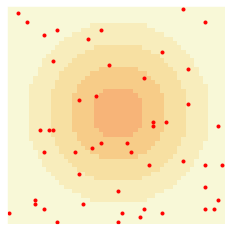

In [380]:
env = Urban_Humanities(50, num_agents=50)
env.draw()
savefig('Initial_Residents.png')

### Demo for the urbanization process
The demo is divided into two phases:
Step 1: Population growth and moving towards the city center
Step2: The population gradually spreads outward and stops growing

Frames and intervals can be changed by your prefer

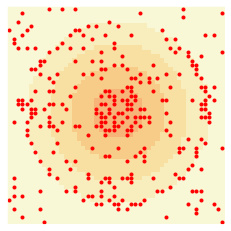

In [381]:
env.animate(frames=100, interval=0.1)

### Heat map of urban population distribution in Beijing in 2022

In [372]:
data = (
    np.random.normal(size=(100, 3)) *
    np.array([[0.1, 0.1, 0.1]]) +
    np.array([[40, 116.5, 1]])
).tolist()
data[:3]

from folium.plugins import HeatMap
Beijing = folium.Map([39.93, 116.38], tiles='stamentoner', zoom_start=10)
HeatMap(data).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=40,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=80,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=120,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=160,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=230,
    color='red',
    fill=False,
).add_to(Beijing)

folium.Marker(
    location=[39.93, 116.38],
    popup='4',
    icon=folium.Icon(color='purple', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[39.93, 116.45],
    popup='3',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40, 116.48],
    popup='2',
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40.01, 116.55],
    popup='1',
    icon=folium.Icon(color='orange', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40.08, 116.58],
    popup='0',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(Beijing)
Beijing.save(os.path.join('Beijing.html'))
Beijing

-Blue-Area 0

-Orange-Area 1

-Green-Area 2

-Red-Area 3

-Purple-Area 4

### Total number of people/year in different areas

Saving figure to file Population


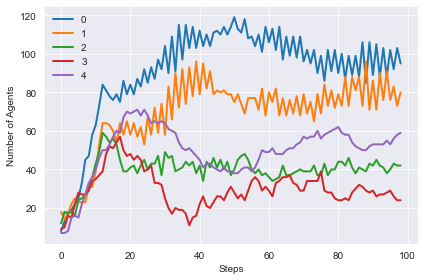

In [373]:
for i, agents in env.agent_level_count.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Number of Agents', loc='upper left')
savefig('Population')

### Wealth per capita/year in different areas

Saving figure to file Average_Wealth


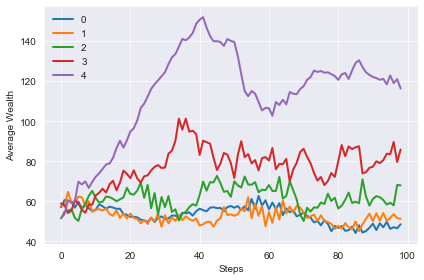

In [374]:
for i, agents in env.agent_level_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Average Wealth', loc='upper left')
savefig('Average_Wealth')

### Highest resident wealth/year in different areas

Saving figure to file Highest_Wealth


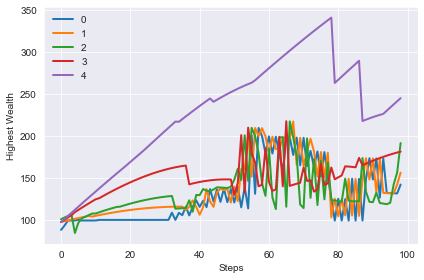

In [375]:
for i, agents in env.agent_level_highest_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Highest Wealth', loc='upper left')
savefig('Highest_Wealth')

### Lowest resident wealth/year in different areas

Saving figure to file Lowest_Wealth


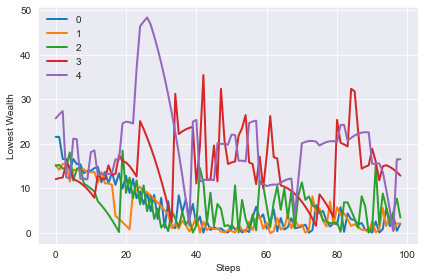

In [376]:
for i, agents in env.agent_level_lowest_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Lowest Wealth', loc='upper left')
savefig('Lowest_Wealth')

##### Thanks for Shannon and Santiago
##### 2022.10.25
